## Código para poder usar la GPU
Si no la tienes deberia uncionar sin problema igual

In [1]:
import tensorflow as tf

# Obtener la lista de dispositivos físicos disponibles
devices = tf.config.list_physical_devices('GPU')

if len(devices) > 0:
  # Configurar TensorFlow para usar la primera GPU disponible
  tf.config.set_visible_devices(devices[0], 'GPU')
  print('Se utilizará la GPU:', devices[0])
else:
  print('No se encontraron dispositivos GPU disponibles.')

2023-03-01 15:50:05.221975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 15:50:05.279841: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-01 15:50:05.553472: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/victorxesus.barreiro/anaconda3/envs/deepgpu4/lib/
2023-03-01 15:50:05.553506: W tensorflow/

Se utilizará la GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2023-03-01 15:50:05.811048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 15:50:05.813792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 15:50:05.813864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
import tensorflow as tf

print("Dispositivo actual: ", tf.test.gpu_device_name())

Dispositivo actual:  /device:GPU:0


2023-03-01 15:50:05.829169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 15:50:05.829689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 15:50:05.829776: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 15:50:05.829815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

# Cargamos los datos

In [3]:
# Dataset path
from os import listdir
import os.path

PATH = './faces_dataset_train/'
PATH_TEST = './faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

# Metadata Access

import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    print(parts)
    gender = tf.cast(0 if parts[2] == 'M' else 1, tf.dtypes.int32)
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, gender

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

ds_train_transform = train_ds
ds_test_transform = test_ds

# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

# OPTIONAL: sample gender weights
import numpy as np
labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
freqs = np.array([1. - np.mean(labels), np.mean(labels)])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-01 15:50:06.410182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 15:50:06.410269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 15:50:06.410315: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 15:50:06.410408: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-01 15:50:06.410449: I tensorflow/compiler/xla/stream_executo

# Funciones auxiliares

In [4]:
from keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import Input, Model
from keras.utils import plot_model

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np

def visualize_fit(history):
    """Procedure to print de evolution of a training process.

    Args:
        history (dict): _description_
    """    
    history_dict = history.history
    history_dict.keys()

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, 'b-o', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r-o', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    plt.plot(epochs, acc, 'b-o', label='Training acc')
    plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def buildModel(input_shape,optimizer,regularizer):
    input = Input(shape=input_shape,name = 'Input_layer')

    conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name = 'First_Convolution')(input)
    pooling1 = MaxPooling2D(pool_size=(2, 2), name = 'First_Pooling')(conv1)
    conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', name = 'Second_Convolution')(pooling1)
    pooling2 = MaxPooling2D(pool_size=(2, 2), name = 'Second_Pooling')(conv2)
    conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu', name = 'Third_Convolution')(pooling2)
    pooling3 = MaxPooling2D(pool_size=(2, 2), name = 'Third_Pooling')(conv3)
    flat = Flatten(name = 'Flatten_Layer')(pooling3)
    dense1 = Dense(128, activation='relu', kernel_regularizer=regularizer, name = 'First_Dense')(flat)
    drop1 = Dropout(0.5, name = 'First_Dropouuuuuuut')(dense1)
    output = Dense(1, activation='sigmoid', name = 'Output_Layer')(drop1)

    model = Model(inputs=input,outputs=output)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'],weighted_metrics=[])
    return model


def fitModel(model,ds_train,ds_val,ds_test,num_epochs=20,batch_size=128,patience=5,monitor='val_loss'):
    early_stopping = EarlyStopping(monitor=monitor, patience=patience, mode='min', verbose=1)
    checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, save_weights_only=True, monitor=monitor, mode='auto', verbose=0)
    history = model.fit(ds_train.batch(batch_size), verbose = 0, epochs=num_epochs,callbacks=[early_stopping, checkpoint],validation_data=ds_val.batch(batch_size))
    print(model.evaluate(ds_test.batch(batch_size)))
    visualize_fit(history)

# Preparación de batches

In [5]:
dataset_size = ds_train_transform.reduce(0, lambda x, _: x + 1).numpy()
dataset_size

126865

In [6]:
ds_train_shuffle = ds_train_transform.shuffle(10000)
ds_train = ds_train_shuffle.skip(int(dataset_size * 0.2))
ds_test = ds_train_shuffle.take(int(dataset_size * 0.2))
ds_val = ds_test_transform

# Modelos

2023-03-01 15:50:13.005365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-01 15:50:13.442995: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-01 15:50:13.838809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-01 15:50:13.840312: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f26a1db0050 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-01 15:50:13.840320: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2023-03-01 15:50:13.847335: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-01 15:50:13.862961: I tensorflow/compiler/jit/xla_compilation

199/199 [==============================] - 1s 4ms/step - loss: 0.4015 - accuracy: 0.8769
[0.4015222191810608, 0.8768770098686218]


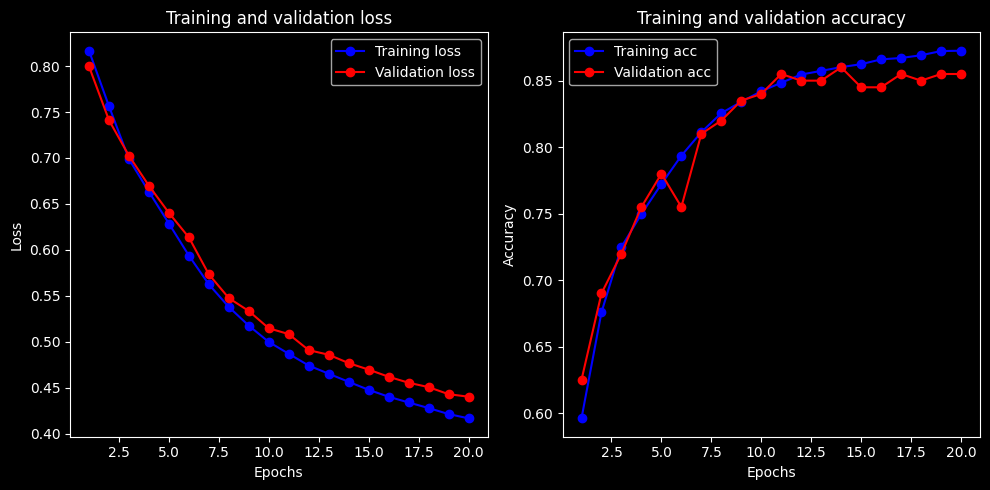

In [7]:
input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
regularizer = regularizers.l2(0.001)

model = buildModel(input_shape,optimizer,regularizer)
fitModel(model,ds_train,ds_val,ds_test,num_epochs=20,batch_size=128,patience=5,monitor='val_loss')

2023-03-01 15:51:30.606133: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


Epoch 10: early stopping
199/199 [==============================] - 1s 3ms/step - loss: 0.3464 - accuracy: 0.8667
[0.3464159369468689, 0.8667480945587158]


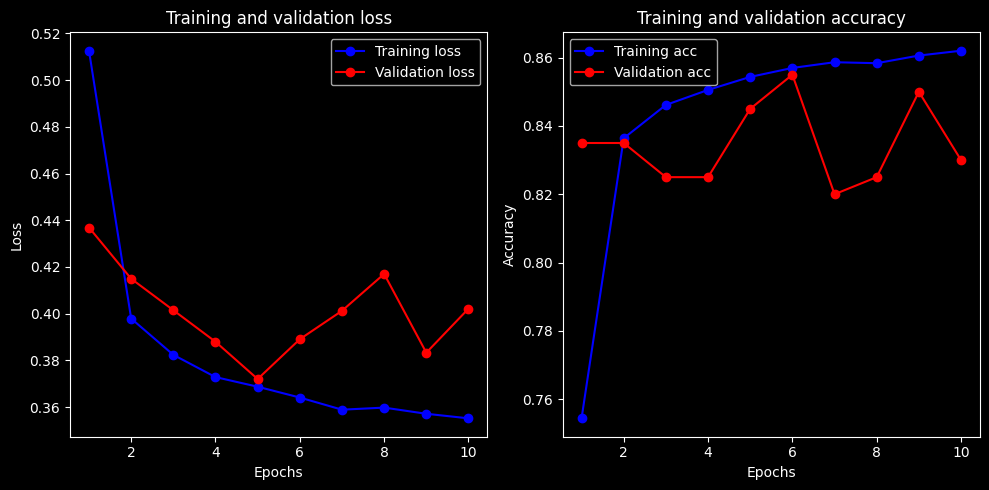

In [8]:
input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
regularizer = regularizers.l2(0.001)

model = buildModel(input_shape,optimizer,regularizer)
fitModel(model,ds_train,ds_val,ds_test,num_epochs=20,batch_size=128,patience=5,monitor='val_loss')

Epoch 9: early stopping
199/199 [==============================] - 1s 3ms/step - loss: 0.3431 - accuracy: 0.8562
[0.34307876229286194, 0.8561857342720032]


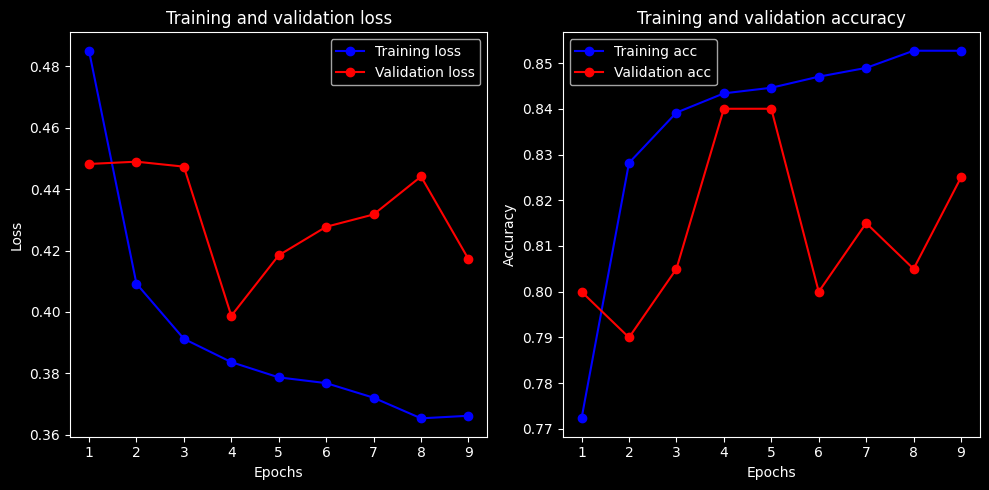

In [9]:
input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
regularizer = regularizers.l2(0.001)

model = buildModel(input_shape,optimizer,regularizer)
fitModel(model,ds_train,ds_val,ds_test,num_epochs=20,batch_size=128,patience=5,monitor='val_loss')

Epoch 9: early stopping
199/199 [==============================] - 1s 3ms/step - loss: 0.2529 - accuracy: 0.9089
[0.2529231905937195, 0.9089189171791077]


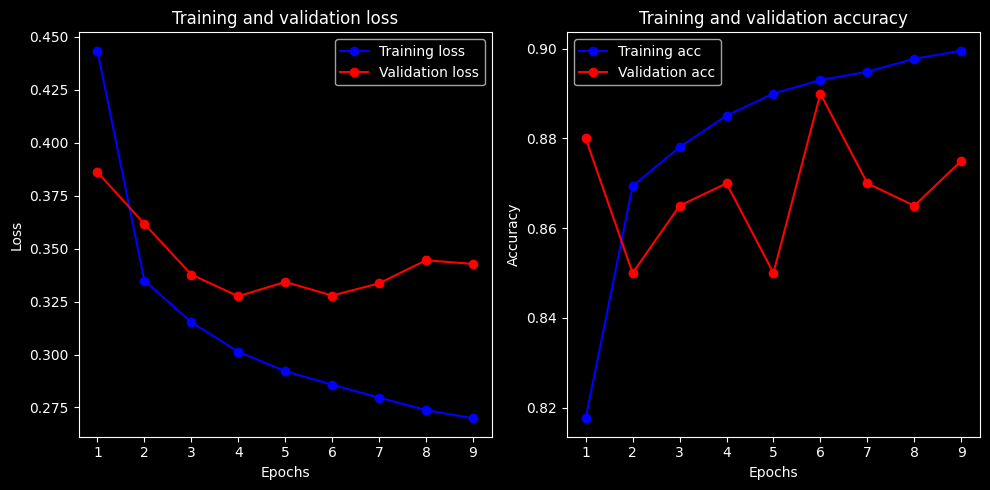

In [10]:
input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
regularizer = regularizers.l2(0.001)

model = buildModel(input_shape,optimizer,regularizer)
fitModel(model,ds_train,ds_val,ds_test,num_epochs=20,batch_size=128,patience=5,monitor='val_loss')

# Pruebas Víctor

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 64)          369

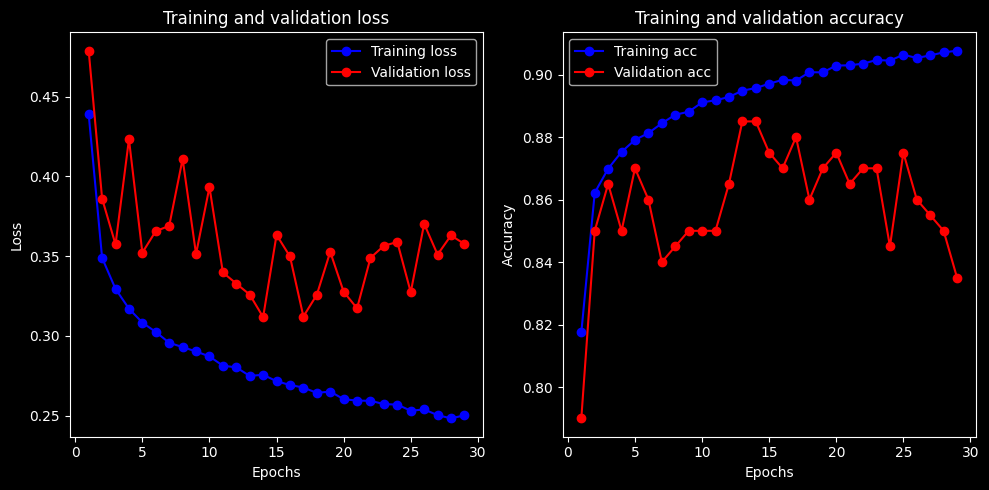

In [19]:
from tensorflow.keras import layers

center = True
scale = True

input_shape = (32, 32, 3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
regularizer = regularizers.l2(0.001)

input = Input(shape=input_shape,name = 'Input_layer')

conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape)(input)
pooling1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pooling1)
pooling2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu')(pooling2)
pooling3 = MaxPooling2D(pool_size=(2, 2))(conv3)
flat = Flatten(name = 'Flatten_Layer')(pooling3)
dense1 = Dense(128, activation='relu', kernel_regularizer=regularizer)(flat)
norm_d1 = layers.BatchNormalization(center=center,scale=scale)(dense1)
dense2 = Dense(64, activation='relu', kernel_regularizer=regularizer)(norm_d1)
norm_d2 = layers.BatchNormalization(center=center,scale=scale)(dense2)
dense3 = Dense(32, activation='relu', kernel_regularizer=regularizer)(dense2)
#drop1 = Dropout(0.5, name = 'First_Dropouuuuuuut')(dense1)
output = Dense(1, activation='sigmoid', name = 'Output_Layer')(dense3)

model = Model(inputs=input,outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'],weighted_metrics=[])

fitModel(model,ds_train,ds_val,ds_test,num_epochs=50,batch_size=128,patience=10,monitor='val_loss')